In [111]:
import os
import math

import pretty_midi
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

from scipy.io import wavfile
from python_speech_features import mfcc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, TensorDataset
import torch.distributed as dist
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall


from accelerate import Accelerator

# Preproccessing

In [2]:
# Change this to directory where the data is stored
raw_data_folder = 'Data/'

## Preprocessing Functions

In [ ]:
def transpose(midi_file, semitones=None):
    """
    Transpose a MIDI file by a given number of semitones.
    """
    if semitones is None:
        semitones = np.random.choice(list(range(-3, 0)) + list(range(1, 4)))
    midi_data = pretty_midi.PrettyMIDI(midi_file)
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            note.pitch += semitones
    return midi_data

def change_tempo(midi_file, factor=None):
    if factor is None:
        factor = np.random.uniform(0.5, 1.5)
    midi_data = pretty_midi.PrettyMIDI(midi_file)
    for tempo_change in midi_data.get_tempo_changes()[1]:
        tempo_change /= factor
    return midi_data

def rhythmic_variation(midi_file, max_variation=None):
    """
    Add a random variation to the start and end times of each note.
    max_variation is in milliseconds.
    """
    if max_variation is None:
        max_variation = np.random.randint(5, 15)
    midi_data = pretty_midi.PrettyMIDI(midi_file)
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            variation = np.random.uniform(-max_variation, max_variation) / 1000.0  # convert to seconds
            note.start += variation
            note.end += variation
            # ensure start is not negative
            note.start = max(0, note.start)
            # ensure end is not less than start
            note.end = max(note.start, note.end)
    return midi_data

def drop_notes(midi_file, drop_probability=None):
    """
    Randomly drop notes with a certain probability.
    """
    if drop_probability is None:
        drop_probability = np.random.uniform(0.05, 0.2)
    midi_data = pretty_midi.PrettyMIDI(midi_file)
    for instrument in midi_data.instruments:
        instrument.notes = [note for note in instrument.notes if np.random.random() >= drop_probability]
    return midi_data

def preprocess_midi_into_mel_and_mfcc(midi_data, segment_length=224, mfcc_segment_length=519, num_cepstral=13):
    audio_data = midi_data.synthesize()
    rate = 44100

    spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=rate, n_mels=224)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    mfcc_features = mfcc(audio_data, samplerate=rate, numcep=num_cepstral, winlen=0.025, winstep=0.01, nfft=1103)

    if spectrogram_db.shape[1] % segment_length != 0:
            spectrogram_db = spectrogram_db[:, :-(spectrogram_db.shape[1] % segment_length)]

    segments = []

    for start in range(0, spectrogram_db.shape[1] - segment_length + 1, segment_length):
        mel_segment = spectrogram_db[:, start:start + segment_length]
        mfcc_start = mfcc_segment_length * (start // segment_length)
        mfcc_end = mfcc_start + mfcc_segment_length
        mfcc_segment = mfcc_features[mfcc_start:mfcc_end, :]
        # Only consider segments that are long enough
        if mfcc_segment.shape[0] == mfcc_segment_length:
            segments.append((mel_segment, mfcc_segment))

    return segments, audio_data, rate

def augment_midi_file(file_path):
    functions = [transpose, change_tempo, rhythmic_variation, drop_notes]
    augmentation_function = np.random.choice(functions)
    augmented_midi = augmentation_function(file_path)
    print('Processed transformed file:', file_path)
    return augmented_midi

def process_directory(dir_to_process, composer, X_mel, X_mfcc, y, audio_time_series_list, sampling_rate_list, sequence_count, TARGET_NUMBER, augment=False):
    for file in os.listdir(dir_to_process):
        if sequence_count[composer] >= TARGET_NUMBER and augment:
            break

        if file.endswith('.mid'):
            file_path = os.path.join(dir_to_process, file)

            # if in augmentation process, randomly transform midi
            if augment:
                midi_obj = augment_midi_file(file_path)
            else:
                midi_obj = pretty_midi.PrettyMIDI(file_path)

            segments, audio_time_series, rate = preprocess_midi_into_mel_and_mfcc(midi_obj)

            if segments is not None:
                audio_time_series_list.append(audio_time_series)
                sampling_rate_list.append(rate)
                for mel_segment, mfcc_segment in segments:
                    X_mel.append(mel_segment)
                    X_mfcc.append(mfcc_segment)
                    y.append(composer)
                    sequence_count[composer] += 1
                    if sequence_count[composer] % 500 == 0:
                        print(sequence_count)


def preprocess_data_in_directory(base_dir, subfolder, augment_data=False):
    y_augmented = []
    X_mel_augmented = []
    X_mfcc_augmented = []

    # Base without augmentation
    y_base = []
    X_mel_base = []
    X_mfcc_base = []

    audio_time_series_list = []
    sampling_rate_list = []

    TARGET_NUMBER = 4000  # target for augmented dataset

    file_dir = base_dir + subfolder
    composers = os.listdir(file_dir)
    # to show progression
    sequence_count = {composer: 0 for composer in composers}

    for composer in composers:
        y = []
        X_mel = []
        X_mfcc = []
        composer_dir = os.path.join(file_dir, composer)
        if os.path.isdir(composer_dir):

            # Process each directory
            process_directory(composer_dir, composer, X_mel, X_mfcc, y, audio_time_series_list, sampling_rate_list, sequence_count, TARGET_NUMBER)

            # Push all original data to _base arrays
            X_mel_base.extend(X_mel)
            X_mfcc_base.extend(X_mfcc)
            y_base.extend(y)

            # if we're augmenting data, add extra bartok directory, and randomly transform midis:
            if augment_data and subfolder == 'train':
                dirs_to_process = [composer_dir]
                if composer.lower() == 'bartok':
                    extra_dir = os.path.join(base_dir, 'Bartok/')
                    process_directory(extra_dir, composer, X_mel, X_mfcc, y, audio_time_series_list, sampling_rate_list, sequence_count, TARGET_NUMBER, augment=False)
                    dirs_to_process.append(extra_dir)
                # if there are too many sequences just in the base, truncate them to balance the data for the augmented sets
                if sequence_count[composer] >= TARGET_NUMBER:
                    print('Excess truncated')
                    y_augmented.extend(y[:TARGET_NUMBER])
                    X_mel_augmented.extend(X_mel[:TARGET_NUMBER])
                    X_mfcc_augmented.extend(X_mfcc[:TARGET_NUMBER])
                    sequence_count[composer] = TARGET_NUMBER
                    print(sequence_count)
                else:
                    while sequence_count[composer] < TARGET_NUMBER:
                        for dir_to_process in dirs_to_process:
                            process_directory(dir_to_process, composer, X_mel, X_mfcc, y, audio_time_series_list, sampling_rate_list, sequence_count, TARGET_NUMBER, augment=True)
                    y_augmented.extend(y[:TARGET_NUMBER])
                    X_mel_augmented.extend(X_mel[:TARGET_NUMBER])
                    X_mfcc_augmented.extend(X_mfcc[:TARGET_NUMBER])

    audio_time_series_list = [np.array(x) for x in audio_time_series_list]
    sampling_rate_list = [np.array(x) for x in sampling_rate_list]

    if augment_data:
        return np.array(X_mel_augmented), np.array(X_mfcc_augmented), np.array(y_augmented), np.array(X_mel_base), np.array(X_mfcc_base), np.array(y_base), audio_time_series_list, sampling_rate_list
    else:
        return np.array(X_mel_base), np.array(X_mfcc_base), np.array(y_base), audio_time_series_list, sampling_rate_list


In [ ]:
midi_data = pretty_midi.PrettyMIDI(raw_data_folder + 'train/bach/bach342.mid')
midi_transposed = transpose(raw_data_folder + 'train/bach/bach342.mid', -5)

In [ ]:
midi_transposed.write(raw_data_folder + 'transposed_bach.mid')

In [ ]:
new_file_list = raw_data_folder + 'Bartok/'
df_new_files = pd.read_csv(new_file_list)

In [ ]:
X_train_mel_augmented, \
X_train_mfcc_augmented, \
y_train_augmented, \
X_train_mel_original, \
X_train_mfcc_original, \
y_train_original, \
audio_time_series_train, \
sampling_rate_train = preprocess_data_in_directory(raw_data_folder, 'train', augment_data=True)
X_test_mel, X_test_mfcc, y_test, audio_time_series_test, sampling_rate_test = preprocess_data_in_directory(raw_data_folder, 'test')
X_dev_mel, X_dev_mfcc, y_dev, audio_time_series_dev, sampling_rate_dev = preprocess_data_in_directory(raw_data_folder, 'dev')

## Encoding Composer Labels

In [6]:
le = LabelEncoder()

y_train_original = le.fit_transform(y_train_original)
y_train_augmented = le.transform(y_train_augmented)
y_test = le.transform(y_test)
y_dev = le.transform(y_dev)

class_list = le.classes_

In [ ]:
class_list

In [ ]:
np.save(raw_data_folder + 'class_list.npy', np.array(class_list))

## Convertin Data into Tensors

In [ ]:
X_train_mel_augmented = torch.from_numpy(X_train_mel_augmented).float()
X_train_mel_augmented = X_train_mel_augmented.unsqueeze(1)

X_train_mfcc_augmented = torch.from_numpy(X_train_mfcc_augmented).float()

y_train_augmented = torch.from_numpy(y_train_augmented).long()

X_test_mel = torch.from_numpy(X_test_mel).float()
X_test_mel = X_test_mel.unsqueeze(1)

X_test_mfcc = torch.from_numpy(X_test_mfcc).float()

y_test = torch.from_numpy(y_test).long()

X_dev_mel = torch.from_numpy(X_dev_mel).float()
X_dev_mel = X_dev_mel.unsqueeze(1)

X_dev_mfcc = torch.from_numpy(X_dev_mfcc).float()

y_dev_ = torch.from_numpy(y_dev).long()

## Standardizing The Mel Spectrogram Data

In [7]:
min_value_mel = X_train_mel_augmented.min()
max_value_mel = X_train_mel_augmented.max()

X_train_mel_augmented_norm = (X_train_mel_augmented - min_value_mel) / (max_value_mel - min_value_mel)
X_test_mel_normalized = (X_test_mel - min_value_mel) / (max_value_mel - min_value_mel)
X_dev_mel_normalized = (X_dev_mel - min_value_mel) / (max_value_mel - min_value_mel)

In [ ]:
# For Mel Spec data, transform to 3 channels, for use with pretrained models
X_train_mel_augmented_norm_rgb = X_train_mel_augmented_norm.repeat(1, 3, 1, 1)
X_test_mel_normalized_rgb = X_test_mel_normalized.repeat(1, 3, 1, 1)
X_dev_mel_normalized_rgb = X_dev_mel_normalized.repeat(1, 3, 1, 1)

## Saving Results

In [10]:
# Saving Results
torch.save(X_train_mel_augmented_norm_rgb, raw_data_folder + 'X_train_mel_augmented_norm_rgb.pt')
torch.save(X_train_mfcc_augmented, raw_data_folder + 'X_train_mfcc_augmented.pt')
torch.save(y_train_augmented, raw_data_folder + 'y_train_augmented.pt')

np.save(raw_data_folder + 'audio_time_series_train.npy', audio_time_series_train)
np.save(raw_data_folder + 'sampling_rate_train.npy', sampling_rate_train)

torch.save(X_test_mel_normalized_rgb, raw_data_folder + 'X_test_mel_normalized_rgb.pt')
torch.save(X_test_mfcc, raw_data_folder + 'X_test_mfcc.pt')
torch.save(y_test, raw_data_folder + 'y_test.pt')

np.save(raw_data_folder + 'audio_time_series_test.npy', audio_time_series_test)
np.save(raw_data_folder + 'sampling_rate_test.npy', sampling_rate_test)

torch.save(X_dev_mel_normalized_rgb, raw_data_folder + 'X_dev_mel_normalized_rgb.pt')
torch.save(X_dev_mfcc, raw_data_folder + 'X_dev_mfcc.pt')
torch.save(y_dev, raw_data_folder + 'y_dev.pt')

np.save(raw_data_folder + 'audio_time_series_dev.npy', audio_time_series_dev)
np.save(raw_data_folder + 'sampling_rate_dev.npy', sampling_rate_dev)

# Feature Extraction

From the preproccessing section the MFCC and Mel data was extracted from audio files

## Loading Data

In [16]:
raw_data_folder = 'Data/'

In [17]:
# Importing Training Data (No Augmenting)
X_train_rgb = torch.load(raw_data_folder + 'X_train_rgb.pt')
X_train_mfcc_denorm = torch.load(raw_data_folder + 'X_train_mfcc_denorm.pt')
y_train = torch.load(raw_data_folder + 'y_train_rgb.pt')
#audio_time_series_train = np.load(raw_data_folder + 'audio_time_series_train.npy', allow_pickle=True)
#sampling_rate_train = np.load(raw_data_folder + 'sampling_rate_train.npy', allow_pickle=True)

X_test_rgb = torch.load(raw_data_folder + 'X_test_rgb.pt')
X_test_mfcc_denorm = torch.load(raw_data_folder + 'X_test_mfcc_denorm.pt')
y_test = torch.load(raw_data_folder + 'y_test_rgb.pt')
#audio_time_series_test = np.load(raw_data_folder + 'audio_time_series_test.npy', allow_pickle=True)
#sampling_rate_test = np.load(raw_data_folder + 'sampling_rate_test.npy', allow_pickle=True)

X_dev_rgb = torch.load(raw_data_folder + 'X_dev_rgb.pt')
X_dev_mfcc_denorm = torch.load(raw_data_folder + 'X_dev_mfcc_denorm.pt')
y_dev = torch.load(raw_data_folder + 'y_dev_rgb.pt')
#audio_time_series_dev = np.load(raw_data_folder + 'audio_time_series_dev.npy', allow_pickle=True)
#sampling_rate_dev = np.load(raw_data_folder + 'sampling_rate_dev.npy', allow_pickle=True)

In [18]:
# Importing Training Data with Augmentation
X_train_mel_augmented_norm_rgb = torch.load(raw_data_folder + 'X_train_mel_augmented_norm_rgb_6000.pt')
X_train_mfcc_augmented = torch.load(raw_data_folder + 'X_train_mfcc_augmented_6000.pt')
y_train_augmented = torch.load(raw_data_folder + 'y_train_augmented_6000.pt')

X_test_mel_normalized_rgb = torch.load(raw_data_folder + 'X_test_mel_normalized_rgb.pt')
X_test_mfcc = torch.load(raw_data_folder + 'X_test_mfcc.pt')

X_dev_mel_normalized_rgb = torch.load(raw_data_folder + 'X_dev_mel_normalized_rgb.pt')
X_dev_mfcc = torch.load(raw_data_folder + 'X_dev_mfcc.pt')

FileNotFoundError: [Errno 2] No such file or directory: 'Data/X_train_mel_augmented_norm_rgb_6000.pt'

In [6]:
# Importing Testing and Validation Labels
y_test = torch.load(raw_data_folder + 'y_test_rgb.pt')
y_dev = torch.load(raw_data_folder + 'y_dev_rgb.pt')

In [19]:
class_list = np.load(raw_data_folder + 'class_list.npy')

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Get unique values and their counts
unique_values, counts = torch.unique(y_train_augmented, return_counts=True)

# Print unique values and their counts
for value, count in zip(unique_values, counts):
    print(f'{value}: {count}')

NameError: name 'y_train_augmented' is not defined

## Visualizing Data

In [10]:
# accumulate composer names for visualizations
composer_names = []
composers = os.listdir(raw_data_folder + 'train')
for composer in composers:
    composer_dir = os.path.join(raw_data_folder + 'train', composer)
    if os.path.isdir(composer_dir):
        for file in os.listdir(composer_dir):
            if file.endswith('.mid'):
                file_path = os.path.join(composer_dir, file)
                composer_names.append(composer)

In [ ]:
# Example Mel Spectrogram's
fig, axs = plt.subplots(2, figsize=(10, 8))

# denormalize the first example
X_train_denorm1 = X_train_rgb[1220][0].cpu() * (max_value_mel - min_value_mel) + min_value_mel

# plot the first example
im1 = axs[0].imshow(X_train_denorm1, cmap='jet', aspect='auto', origin='lower')
axs[0].set_title(f'Mel spectrogram, {class_list[y_train[1220]]}')
fig.colorbar(im1, ax=axs[0], format='%+2.0f dB')

# denormalize the second example
X_train_denorm2 = X_train_rgb[13450][0].cpu() * (max_value_mel - min_value_mel) + min_value_mel

# plot the second example
im2 = axs[1].imshow(X_train_denorm2, cmap='jet', aspect='auto', origin='lower')
axs[1].set_title(f'Mel spectrogram, {class_list[y_train[13450]]}')
fig.colorbar(im2, ax=axs[1], format='%+2.0f dB')

plt.tight_layout()
plt.show()

In [ ]:
# Example MFCC's
fig, axs = plt.subplots(2, figsize=(10, 8))
im1 = axs[0].imshow(X_train_mfcc[1220][0].cpu(), cmap='jet', aspect='auto', origin='lower')
axs[0].set_title(f'MFCC, {class_list[y_train[1220]]}')

im2 = axs[1].imshow(X_train_mfcc[13450][0].cpu(), cmap='jet', aspect='auto', origin='lower')
axs[1].set_title(f'MFCC, {class_list[y_train[13450]]}')
fig.colorbar(im2, ax=axs[1], format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [ ]:
def compute_energy(mel_spectrogram):
    return torch.sum(mel_spectrogram**2, axis=1)

# Convert y_train to a numpy array
y_train_np = np.array(y_train.cpu())

# Compute the mean energy for each Mel-spectrogram in training set
mean_energies = [torch.mean(compute_energy(mel_spectrogram)).item() for mel_spectrogram in X_train_mel]

composer_names = [class_list[i] for i in y_train_np]
data = pd.DataFrame({'Composer': composer_names, 'Mean Energy': mean_energies})

# Group by composer and compute the mean of the mean energies
grouped = data.groupby('Composer')['Mean Energy'].mean()

# Plot a bar chart of the mean energies by composer
grouped.plot(kind='bar')
plt.ylabel('Mean Energy')
plt.title('Mean Energy by Composer')
plt.show()

In [ ]:
def compute_spectral_contrast(mel_spectrogram):
    # Convert the tensor to a numpy array and compute the spectral contrast
    mel_spectrogram_np = mel_spectrogram.cpu().numpy()
    spectral_contrast = librosa.feature.spectral_contrast(S=mel_spectrogram_np)
    return np.mean(spectral_contrast)

# Compute the mean spectral contrast for each Mel-spectrogram in training set
mean_spectral_contrasts = [compute_spectral_contrast(mel_spectrogram) for mel_spectrogram in X_train_mel]

# Map integer labels to composer names
composer_names = [class_list[i] for i in y_train_np]

# Combine the composers and mean spectral contrasts into a DataFrame
data = pd.DataFrame({'Composer': composer_names, 'Mean Spectral Contrast': mean_spectral_contrasts})

# Group by composer and compute the mean of the mean spectral contrasts
grouped = data.groupby('Composer')['Mean Spectral Contrast'].mean()

# Plot a bar chart of the mean spectral contrasts by composer
grouped.plot(kind='bar')
plt.ylabel('Mean Spectral Contrast')
plt.title('Mean Spectral Contrast by Composer')
plt.show()

In [ ]:
# Calculate chroma features for each audio file
chroma_features = [librosa.feature.chroma_stft(y=audio_time_series, sr=sampling_rate) for audio_time_series, sampling_rate in zip(audio_time_series_train, sampling_rate_train)]

# Compute the mean chroma feature for each audio file
mean_chroma_features = [np.mean(chroma_feature, axis=1) for chroma_feature in chroma_features]

# Convert the list of mean chroma features to a 2D array
mean_chroma_features_array = np.array(mean_chroma_features)

# Combine the composers and mean chroma features into a DataFrame
data = pd.DataFrame(mean_chroma_features_array, columns=[f'Chroma {i+1}' for i in range(12)])
data['Composer'] = composer_names

# Melt the DataFrame to long format for plotting
data_melted = pd.melt(data, id_vars='Composer', var_name='Chroma', value_name='Mean Chroma Feature')

In [ ]:
# Plot a boxplot of the mean chroma features by composer
plt.figure(figsize=(15,8))
ax = sns.boxplot(x='Composer', y='Mean Chroma Feature', hue='Chroma', data=data_melted)
ax.legend_.remove()
plt.title('Mean Chroma Features by Composer')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.show()

## Weighted Random Sampling

In [8]:
# Get unique values and their counts
unique_values, counts = torch.unique(y_train.cpu(), return_counts=True)

# Print unique values and their counts
for value, count in zip(unique_values, counts):
    print(f'{value}: {count}')

0.0: 2253
1.0: 1167
2.0: 1912
3.0: 2157
4.0: 1931
5.0: 4646
6.0: 2205
7.0: 3951
8.0: 2528


In [9]:
# Setting Class Weights
target = torch.Tensor.numpy(y_train.cpu())
target = target.astype('int')
class_sample_counts = np.array([len(np.where(target == t)[0]) for t in np.unique(target)])
class_weights = [1/class_sample_counts[i] for i in target]
len(class_weights)

22750

In [10]:
sampler = WeightedRandomSampler(weights = class_weights, num_samples = len(class_weights), replacement = True)

['bach',
 'bartok',
 'byrd',
 'chopin',
 'handel',
 'hummel',
 'mendelssohn',
 'mozart']

## Making Mel DataLoader

In [19]:
class MelDataset(Dataset):
    def __init__(self, X_mel, y, class_list):
        self.X_mel = X_mel
        self.y = y
        self.class_list = class_list

    def __len__(self):
        return len(self.X_mel)

    def __getitem__(self, idx):
        return self.X_mel[idx], self.y[idx]

    def classes(self):
        # Return the list of class labels
        return self.class_list

In [20]:
# No Augmentation
batch_size = 32

train_dataset_mel = MelDataset(X_train_rgb, y_train, class_list)
test_dataset_mel = MelDataset(X_test_rgb, y_test, class_list)
val_dataset_mel = MelDataset(X_dev_rgb, y_dev, class_list)

# Create the DataLoader
train_loader_mel = DataLoader(train_dataset_mel, sampler = sampler,  batch_size=batch_size)
test_loader_mel = DataLoader(test_dataset_mel, batch_size=batch_size, shuffle=False)
val_loader_mel = DataLoader(val_dataset_mel, batch_size=batch_size, shuffle=False)

In [15]:
# With Augmentation
batch_size = 32

train_dataset_mel_aug = MelDataset(X_train_mel_augmented_norm_rgb, y_train_augmented, class_list)
test_dataset_mel_aug = MelDataset(X_test_mel_normalized_rgb, y_test, class_list)
val_dataset_mel_aug = MelDataset(X_dev_mel_normalized_rgb, y_dev, class_list)

# Create the DataLoader
train_loader_mel_aug = DataLoader(train_dataset_mel_aug,  batch_size=batch_size, shuffle = True)
test_loader_mel_aug = DataLoader(test_dataset_mel_aug, batch_size=batch_size, shuffle=False)
val_loader_mel_aug = DataLoader(val_dataset_mel_aug, batch_size=batch_size, shuffle=False)

NameError: name 'X_train_mel_augmented_norm_rgb' is not defined

## Making MFCC Dataloader

In [21]:
class MFCCDataset(Dataset):
    def __init__(self, X_mfcc, y, class_list):
        self.X_mfcc = X_mfcc
        self.y = y
        self.class_list = class_list

    def __len__(self):
        return len(self.X_mfcc)

    def __getitem__(self, idx):
        return self.X_mfcc[idx], self.y[idx]

    def classes(self):
        # Return the list of class labels
        return self.class_list

In [22]:
# No Augmentation
batch_size = 32

train_dataset_mfcc = MFCCDataset(X_train_mfcc_denorm, y_train, class_list) 
test_dataset_mfcc = MFCCDataset(X_test_mfcc_denorm, y_test, class_list) 
val_dataset_mfcc = MFCCDataset(X_dev_mfcc_denorm, y_dev, class_list) 

# Create the DataLoader
train_loader_mfcc = DataLoader(train_dataset_mfcc, sampler = sampler,  batch_size=batch_size)
test_loader_mfcc = DataLoader(test_dataset_mfcc, batch_size=batch_size, shuffle=False)
val_loader_mfcc = DataLoader(val_dataset_mfcc, batch_size=batch_size, shuffle=False)

In [ ]:
# With Augmentation
batch_size = 32

train_dataset_mfcc_aug = MFCCDataset(X_train_mfcc_augmented, y_train_augmented, class_list) 
test_dataset_mfcc_aug = MFCCDataset(X_test_mfcc, y_test, class_list) 
val_dataset_mfcc_aug = MFCCDataset(X_dev_mfcc, y_dev, class_list) 

# Create the DataLoader
train_loader_mfcc = DataLoader(train_dataset_mfcc_aug, atch_size=batch_size, shuffle = True)
test_loader_mfcc = DataLoader(test_dataset_mfcc_aug, batch_size=batch_size, shuffle=False)
val_loader_mfcc = DataLoader(val_dataset_mfcc_aug, batch_size=batch_size, shuffle=False)

## Making MEL and MFCC Dataloader

In [23]:
class CombinedDataset(Dataset):
    def __init__(self, X_mel, X_mfcc, y, class_list):
        self.X_mel = X_mel
        self.X_mfcc = X_mfcc
        self.y = y
        self.class_list = class_list

    def __len__(self):
        return len(self.X_mfcc)

    def __getitem__(self, idx):
        return self.X_mel[idx], self.X_mfcc[idx], self.y[idx]

    def classes(self):
        # Return the list of class labels
        return self.class_list

In [24]:
# No Augmentation
batch_size = 32

train_dataset_combined = CombinedDataset(X_train_rgb, X_train_mfcc_denorm, y_train, class_list)
test_dataset_combined = CombinedDataset(X_test_rgb, X_test_mfcc_denorm, y_test, class_list)
val_dataset_combined = CombinedDataset(X_dev_rgb, X_dev_mfcc_denorm, y_dev, class_list)

# Create the DataLoader
train_loader_combined = DataLoader(train_dataset_combined, sampler = sampler,  batch_size=batch_size)
test_loader_combined = DataLoader(test_dataset_combined, batch_size=batch_size, shuffle=False)
val_loader_combined = DataLoader(val_dataset_combined, batch_size=batch_size, shuffle=False)

In [ ]:
# With Augmentation
batch_size = 32

train_dataset_combined_aug = CombinedDataset(X_train_mel_augmented_norm_rgb, X_train_mfcc_augmented, y_train_augmented, class_list)
test_dataset_combined_aug = CombinedDataset(X_test_mel_normalized_rgb, X_test_mfcc, y_test, class_list)
val_dataset_combined_aug = CombinedDataset(X_dev_mel_normalized_rgb, X_dev_mfcc, y_dev, class_list)

# Create the DataLoader
train_loader_combined_aug = DataLoader(train_dataset_combined_aug, batch_size=batch_size, shuffle = True)
test_loader_combined_aug = DataLoader(test_dataset_combined_aug, batch_size=batch_size, shuffle=False)
val_loader_combined_aug = DataLoader(val_dataset_combined_aug, batch_size=batch_size, shuffle=False)

# Model Building

In [25]:
class MEL_CNN(nn.Module):
    def __init__(self, num_hidden_layers, init_filters, num_classes, dropout_rate=0.2):
        super(MEL_CNN, self).__init__()
        self.hidden_layers = num_hidden_layers
        
        #Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Input Layer
        self.layers = nn.ModuleDict()
        self.layers["input_Conv"] = nn.Conv2d(3, init_filters, kernel_size=3, padding=1)
        self.layers["input_batch_norm"] = nn.BatchNorm2d(init_filters)
        
        # Hidden Layers
        for i in range(num_hidden_layers):
            in_channels = 2 ** i * init_filters
            out_channels = in_channels * 2
            self.layers[f"hidden_{i}"] = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)
            self.layers[f"batch_norm_{i}"] = nn.BatchNorm2d(out_channels)
        
        # Last Layer
        final_in_channels = 2 ** num_hidden_layers * init_filters
        final_out_channels = final_in_channels * 4
        self.layers["output_Conv"] = nn.Conv2d(final_in_channels, final_out_channels, kernel_size = 1)
        self.layers["output_batch_norm"] = nn.BatchNorm2d(final_out_channels)
        self.layers["linear"] = nn.Linear(final_out_channels, 128)
        self.layers["dropout"] = nn.Dropout(p = dropout_rate)
        self.layers["linear_output_1"] = nn.Linear(128, 64)
        self.layers["linear_output_2"] = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.layers["input_batch_norm"](self.layers["input_Conv"](x))))
        for i in range(self.hidden_layers):
            x = self.pool(nn.functional.relu(self.layers[f"batch_norm_{i}"](self.layers[f"hidden_{i}"](x))))
            
        x = self.pool(nn.functional.relu(self.layers["output_batch_norm"](self.layers["output_Conv"](x))))
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.layers["linear"](x))
        x = self.layers["dropout"](x)
        x = nn.functional.relu(self.layers["linear_output_1"](x))
        x = self.layers["linear_output_2"](x)
        return x # Don't need softmax in the forward function since we're using cross-entropy loss, which implicitly performs softmax


In [26]:
class MFCC_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(MFCC_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)  # Multiply by 2 because it's bidirectional
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)  # Multiply by 2 because it's bidirectional

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # shape = (batch_size, seq_length, hidden_size*2)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [27]:
class CNN_LSTM_Ensemble(nn.Module):
    def __init__(self, model_CNN, model_LSTM, num_class):
        super(CNN_LSTM_Ensemble, self).__init__()
        self.LSTM = model_LSTM
        self.CNN = model_CNN

        fc_input_size = model_CNN.final_out_channel + model_LSTM.hidden_size*2
        
        # Define additional fully-connected layers
        self.fc1 = nn.Linear(fc_input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
    
    def forward(self, MEL, MFCC):
        output_CNN = self.CNN(MEL)
        output_LSTM = self.LSTM(MFCC)
        output = torch.cat((output_CNN, output_LSTM), dim = 1)
        
        output = nn.functional.relu(self.fc1(output))
        output = nn.functional.relu(self.fc2(output))
        output = self.fc3(output)
        return output

# Model Training

In [143]:
def train_model(model, optimizer, scheduler, train_loader, test_loader, ensemble=False, num_epochs=100, patience=10, model_id = "Best_Model.pt"):
    criterion = nn.CrossEntropyLoss()
    #Training Results
    train_losses = []
    train_accuracies = []
    train_prec = []
    train_recall = []
    train_f1 = []
    # Testing Results
    test_losses = []
    test_accuracies = []
    test_prec = []
    test_recall = []
    test_f1 = []
    #Patience
    best_test_loss = float('inf')
    epochs_no_improve = 0
    
    # Metric Dictionary
    train_metrics = MetricCollection([MulticlassAccuracy(num_classes = 9), 
                     MulticlassPrecision(num_classes = 9), 
                     MulticlassRecall(num_classes = 9)])
    
    test_metrics = MetricCollection([MulticlassAccuracy(num_classes = 9), 
                     MulticlassPrecision(num_classes = 9), 
                     MulticlassRecall(num_classes = 9)])

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, batch in enumerate(train_loader):
            if ensemble:
                mel_inputs, mfcc_inputs, labels = batch
                mel_inputs, mfcc_inputs, labels = mel_inputs.to(device), mfcc_inputs.to(device), labels.to(device)
                outputs = model(mel_inputs, mfcc_inputs)
            else:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

            # Compute loss
            labels=labels.to(torch.int64)
            loss = criterion(outputs, labels)
            
            # Update Metrics
            train_metrics.update(outputs.cpu(), labels.cpu())

            '''
            # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            labels = labels.long()
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            '''
            
            # Backward pass and optimization
            optimizer.zero_grad()
            accelerator.backward(loss)
            optimizer.step()
            if ensemble:
                train_loss += loss.item() * mel_inputs.size(0)
            else:
                train_loss += loss.item() * inputs.size(0)

        # Compute Metrics
        train_loss /= len(train_loader.dataset)
        train_metrics_results = train_metrics.compute()
        train_accuracy = train_metrics_results["MulticlassAccuracy"].item()
        train_single_prec = train_metrics_results["MulticlassPrecision"].item()
        train_single_recall = train_metrics_results["MulticlassRecall"].item()
        train_single_f1 = 2 * (train_single_prec*train_single_recall)/(train_single_prec+train_single_recall)
        
        # Append Results
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_prec.append(train_single_prec)
        train_recall.append(train_single_recall)
        train_f1.append(train_single_f1)
        
        
        accelerator.wait_for_everyone()
        unwrapped_model = accelerator.unwrap_model(model)

        # Evaluation
        with torch.no_grad():
            test_loss = 0.0
            test_correct = 0
            test_total = 0

            for batch in test_loader:
                if ensemble:
                    mel_inputs, mfcc_inputs, labels = batch
                    mel_inputs, mfcc_inputs, labels = mel_inputs.to(device), mfcc_inputs.to(device), labels.to(device)
                    outputs = model(mel_inputs, mfcc_inputs)
                else:
                    inputs, labels = batch
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    
                '''
                _, predicted = torch.max(outputs.data, 1)
                
                '''
                # Update Metrics
                test_metrics.update(outputs.cpu(), labels.cpu())

                
                # Compute accuracy and loss
                labels=labels.to(torch.int64)
                
                if ensemble:
                    test_loss += criterion(outputs, labels).item() * mel_inputs.size(0)
                
                else:
                    test_loss += criterion(outputs, labels).item() * inputs.size(0)
                '''
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
                '''
        # Compute Metrics
        test_loss /= len(test_loader.dataset)
        test_metrics_results = test_metrics.compute()
        test_accuracy = test_metrics_results["MulticlassAccuracy"].item()
        test_single_prec = test_metrics_results["MulticlassPrecision"].item()
        test_single_recall = test_metrics_results["MulticlassRecall"].item()
        test_single_f1 = 2 * (test_single_prec*test_single_recall)/(test_single_prec+test_single_recall)
        # Append Results
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        test_prec.append(test_single_prec)
        test_recall.append(test_single_recall)
        test_f1.append(test_single_f1)
        
        # Reset All Metrics
        train_metrics.reset()
        test_metrics.reset()
        
        print(f'Epoch {epoch}, train loss: {train_loss:.4f}, train accuracy: {train_accuracy:.2f}, test loss: {test_loss:.4f}, test accuracy: {test_accuracy:.2f}, learning rate: {scheduler.get_lr()[0]}')

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
            print('Saving model!')
            torch.save(model.state_dict(), model_id)
        else:
            epochs_no_improve += 1
            if epochs_no_improve in [20, 30, 40]:
                print('Stepping lr_scheduler')
                scheduler.step()
            if epochs_no_improve == patience:
                print('Early stopping!')
                break
    results = {
        'train_losses': train_losses,
        'train_Accuracies': train_accuracies,
        'train_Precision': train_prec,
        'train_Recall': train_recall,
        'train_F1': train_f1,
        'test_losses': test_losses,
        'test_Accuracies': test_accuracies,
        'test_Precision': test_prec,
        'test_Recall': test_recall,
        'test_F1': test_f1,
        'best_test_loss': best_test_loss
    }
    return results

In [175]:
def plot_model_summary(results):
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 2, 1)
    plt.plot(range(len(results['train_losses'])), results['train_losses'], label='Training Loss')
    plt.plot(range(len(results['test_losses'])), results['test_losses'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.subplot(2, 2, 2)
    plt.plot(range(len(results['train_Accuracies'])), results['train_Accuracies'], label='Training Accuracy')
    plt.plot(range(len(results['test_Accuracies'])), results['test_Accuracies'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(2, 2, 3)
    plt.plot(range(len(results['train_Precision'])), results['train_Precision'], label='Training Precision')
    plt.plot(range(len(results['test_Precision'])), results['test_Precision'], label='Validation Precision')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Precision')
             
    plt.subplot(2, 2, 4)
    plt.plot(range(len(results['train_Recall'])), results['train_Recall'], label='Training Recall')
    plt.plot(range(len(results['test_Recall'])), results['test_Recall'], label='Validation Recall')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Recall')
    plt.show()

## Test CNN Model

In [31]:
hl = 2
init = 8
num_classes = len(torch.unique(y_train))
dropout = 0.5
test_model = MEL_CNN(hl, init, num_classes, dropout)

print(test_model)

MEL_CNN(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layers): ModuleDict(
    (input_Conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (input_batch_norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden_0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm_0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (output_Conv): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
    (output_batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear): Linear(in_features=128, out_features=128, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (linear_output_1): Linear(in_features=128,

In [35]:
patience = 10
num_epochs = 50
lr = 0.001
weight_decay=0.005
optimizer = torch.optim.Adam(test_model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

accelerator = Accelerator()
test_model, optimizer, train_loader_mel, test_loader_mel = accelerator.prepare(
test_model, optimizer, train_loader_mel, test_loader_mel
)

In [40]:
cnn_results = train_model(test_model, optimizer, scheduler, train_loader_mel, test_loader_mel, ensemble=False, num_epochs=num_epochs, patience=patience, model_id="Best_MEL_CNN.pt")

Epoch 0, train loss: 1.9713, train accuracy: 0.40, test loss: 2.0165, test accuracy: 0.38, learning rate: 0.001
Saving model!
Epoch 1, train loss: 1.9622, train accuracy: 0.41, test loss: 2.0151, test accuracy: 0.34, learning rate: 0.001
Saving model!
Epoch 2, train loss: 2.0005, train accuracy: 0.36, test loss: 2.0101, test accuracy: 0.35, learning rate: 0.001
Saving model!
Epoch 3, train loss: 1.9742, train accuracy: 0.40, test loss: 1.9875, test accuracy: 0.37, learning rate: 0.001
Saving model!
Epoch 4, train loss: 1.9774, train accuracy: 0.40, test loss: 1.9772, test accuracy: 0.40, learning rate: 0.001
Saving model!
Epoch 5, train loss: 1.9762, train accuracy: 0.40, test loss: 1.9916, test accuracy: 0.38, learning rate: 0.001
Epoch 6, train loss: 1.9750, train accuracy: 0.40, test loss: 1.9766, test accuracy: 0.40, learning rate: 0.001
Saving model!
Epoch 7, train loss: 1.9761, train accuracy: 0.40, test loss: 1.9733, test accuracy: 0.41, learning rate: 0.001
Saving model!
Epoch 

## Test LSTM Model

In [140]:
input_size = 13
hidden_size = 32
num_layers = 2
num_classes = len(torch.unique(y_train.cpu()))

lstm_test_model = MFCC_LSTM(input_size, hidden_size, num_layers, num_classes)

print(lstm_test_model)

MFCC_LSTM(
  (lstm): LSTM(13, 32, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=64, out_features=9, bias=True)
)


In [144]:
patience = 5
num_epochs = 25
lr = 0.001
weight_decay = 0.01

optimizer = torch.optim.Adam(lstm_test_model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

accelerator = Accelerator()
lstm_test_model, optimizer, train_loader_mfcc, test_loader_mfcc = accelerator.prepare(
lstm_test_model, optimizer, train_loader_mfcc, test_loader_mfcc
)

In [145]:
lstm_results = train_model(lstm_test_model, optimizer, scheduler, train_loader_mfcc, test_loader_mfcc, ensemble=False, num_epochs=num_epochs, patience=patience, model_id="Best_MFCC_LSTM.pt")

Epoch 0, train loss: 1.7766, train accuracy: 0.33, test loss: 1.8389, test accuracy: 0.32, learning rate: 0.001
Saving model!
Epoch 1, train loss: 1.7290, train accuracy: 0.34, test loss: 1.8380, test accuracy: 0.30, learning rate: 0.001
Saving model!
Epoch 2, train loss: 1.6913, train accuracy: 0.36, test loss: 1.7736, test accuracy: 0.35, learning rate: 0.001
Saving model!
Epoch 3, train loss: 1.6562, train accuracy: 0.37, test loss: 1.7322, test accuracy: 0.34, learning rate: 0.001
Saving model!
Epoch 4, train loss: 1.6630, train accuracy: 0.38, test loss: 1.7331, test accuracy: 0.35, learning rate: 0.001
Epoch 5, train loss: 1.6535, train accuracy: 0.38, test loss: 1.7574, test accuracy: 0.34, learning rate: 0.001
Epoch 6, train loss: 1.6200, train accuracy: 0.40, test loss: 1.7029, test accuracy: 0.38, learning rate: 0.001
Saving model!
Epoch 7, train loss: 1.6144, train accuracy: 0.40, test loss: 1.6880, test accuracy: 0.39, learning rate: 0.001
Saving model!
Epoch 8, train loss:

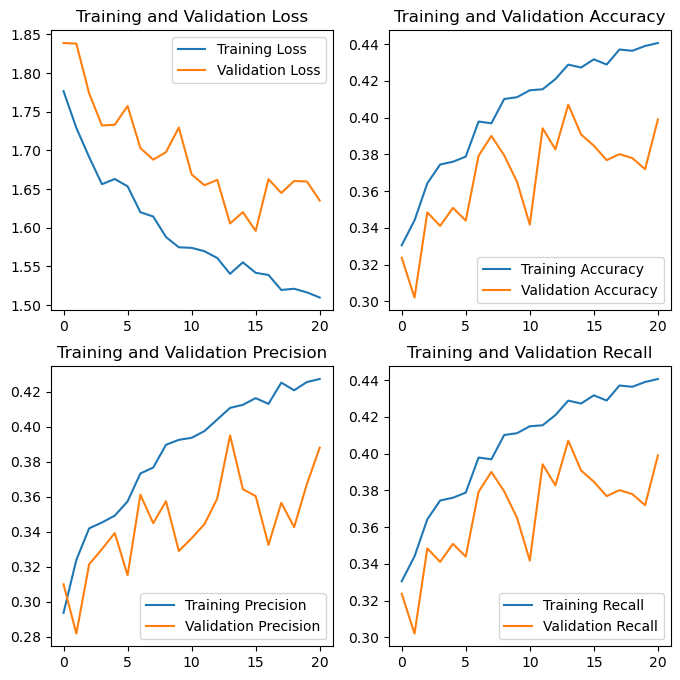

In [176]:
plot_model_summary(lstm_results)

## Testing Ensemble Model 

In [111]:
# Mel Model
hl = 2
init = 8
num_classes = len(torch.unique(y_train.cpu()))
dropout = 0.5
mel_model = MEL_CNN(hl, init, num_classes, dropout)

print(mel_model)

mel_model = mel_model.to(device)

MEL_CNN(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layers): ModuleDict(
    (input_Conv): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (input_batch_norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden_0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm_0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (output_Conv): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
    (output_batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear): Linear(in_features=128, out_features=128, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (linear_output_1): Linear(in_features=128,

In [112]:
# MFCC model
input_size = 13
hidden_size = 32
num_layers = 2
num_classes = len(torch.unique(y_train.cpu()))

mfcc_model = MFCC_LSTM(input_size, hidden_size, num_layers, num_classes)

print(mfcc_model)
mfcc_model = mfcc_model.to(device)

MFCC_LSTM(
  (lstm): LSTM(13, 32, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=64, out_features=9, bias=True)
)


In [120]:
# Ensemble
test_ensemble = CNN_LSTM_Ensemble(mel_model, mfcc_model, num_classes)
print(test_ensemble)
test_ensemble = test_ensemble.to(device)

CNN_LSTM_Ensemble(
  (LSTM): MFCC_LSTM(
    (lstm): LSTM(13, 32, num_layers=2, batch_first=True, bidirectional=True)
    (fc): Linear(in_features=64, out_features=9, bias=True)
  )
  (CNN): MEL_CNN(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (layers): ModuleDict(
      (input_Conv): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (input_batch_norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (hidden_0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm_0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (hidden_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (output_Conv): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
      (output_batch_norm): BatchNorm2d(128, eps=1e-05, m

In [121]:
patience = 10
num_epochs = 50
lr = 0.001
weight_decay = 0.01

optimizer = torch.optim.Adam(test_ensemble.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

accelerator = Accelerator()
test_ensemble, optimizer, train_loader_combined, test_loader_combined = accelerator.prepare(
test_ensemble, optimizer, train_loader_combined, test_loader_combined
)

In [122]:
ensemble_results = train_model(test_ensemble, optimizer, scheduler, train_loader_combined, test_loader_combined, ensemble=True, num_epochs=num_epochs, patience=patience, model_id="Best_Ensemble.pt")

Epoch 0, train loss: 2.1979, train accuracy: 0.10, test loss: 2.1982, test accuracy: 0.05, learning rate: 0.001
Saving model!


NameError: name 'model_id' is not defined

# Evaluation

In [130]:
def calculate_metrics(model, test_loader, ensemble=False):
    model.eval()
    metrics = MetricCollection([MulticlassAccuracy(num_classes = 9), 
                     MulticlassPrecision(num_classes = 9), 
                     MulticlassRecall(num_classes = 9)])
    results = {}
    with torch.no_grad():
        for batch in test_loader:
            if ensemble:
                mel_inputs, mfcc_inputs, labels = batch
                mel_inputs = mel_inputs.to(device)  # Move inputs to the device
                mfcc_inputs = mfcc_inputs.to(device)
                labels = labels.to(device)  # Move labels to the device
                outputs = model(mel_inputs, mfcc_inputs)
            else:
                inputs, labels = batch
                inputs = inputs.to(device)  # Move inputs to the device
                labels = labels.to(device)  # Move labels to the device
                outputs = model(inputs)
            '''
            _, predicted = torch.max(outputs.data, 1)
            '''
            # Update Metrics
            metrics.update(outputs.cpu(), labels.cpu())
    
    metric_results=metrics.compute()
    acc = metric_results['MulticlassAccuracy'].item()
    prec = metric_results['MulticlassPrecision'].item()
    recall = metric_results['MulticlassRecall'].item()
    f1 = 2 * (prec*recall)/(prec+recall)
    results = {'Accuracy': acc, 'Precision': prec, 'Recall': recall, 'F1': f1}
    print("Accuracy %f, Precision %f, Recall %f, F1 %f"  % (acc, prec, recall, f1))
    return results

In [ ]:
cnn_val_accuracy = calculate_accuracy(cnn_model, val_loader_mel)
print(f'CNN Validation Accuracy: {cnn_val_accuracy:.4f}')

In [132]:
lstm_val_results = calculate_metrics(lstm_test_model, val_loader_mfcc)

Accuracy 0.378457, Precision 0.374081, Recall 0.378457, F1 0.376256


In [ ]:
ensemble_val_accuracy = calculate_accuracy(ensemble_model, val_loader_combined, ensemble=True)
print(f'Ensemble Validation Accuracy: {ensemble_val_accuracy:.4f}')

In [ ]:
def create_confusion_matrix(model, test_loader, num_classes):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for mel_inputs, labels in test_loader:
            mel_inputs = mel_inputs.to(device)  # Move inputs to the device
            labels = labels.to(device)  # Move labels to the device

            # Forward pass
            outputs = model(mel_inputs)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Create the confusion matrix
    cm = confusion_matrix(all_labels, all_predictions, labels=np.arange(num_classes))
    return cm

def plot_confusion_matrix(confusion_mtx, labels):
    # Normalize the confusion matrix
    confusion_mtx = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create a heatmap using seaborn
    sns.heatmap(confusion_mtx, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)

    # Set labels and title
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')

    # Rotate x-axis labels if needed
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()

In [ ]:
num_classes = len(torch.unique(y_dev))
confusion_mtx = create_confusion_matrix(model, val_loader, num_classes)
class_labels = val_loader.dataset.classes()
plot_confusion_matrix(confusion_mtx, class_labels)

In [ ]:
mel_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader_mel:
        inputs = inputs.to(device)  # Move inputs to the device (e.g., GPU)
        labels = labels.to(device)  # Move labels to the device

        # Forward pass
        outputs = mel_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Update counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total

print(f'Validation Accuracy: {accuracy:.4f}')

In [ ]:
mel_model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader_mel:
        inputs = inputs.to(device)  # Move inputs to the device (e.g., GPU)
        labels = labels.to(device)  # Move labels to the device

        # Forward pass
        outputs = mel_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create the confusion matrix
cm = confusion_matrix(all_labels, all_predictions, labels=np.arange(num_classes))

# Normalize the confusion matrix
confusion_mtx = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))


class_labels = val_loader.dataset.classes()
# Create a heatmap using seaborn
sns.heatmap(confusion_mtx, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=ax)

# Set labels and title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Show the plot
plt.show()